# GNN模型预测版图寄生电容

## Debug 设置

In [1]:
import faulthandler


faulthandler.enable()

## 参数解析

In [2]:
import sys
import argparse
from config import *


sys.argv = ['run.py']

def str2bool(v):
	if v.lower() in ('yes', 'true', 't', 'y', '1'):
		return True
	elif v.lower() in ('no', 'false', 'f', 'n', '0'):
		return False
	else:
		raise argparse.ArgumentTypeError('Boolean value expected.')

parser = argparse.ArgumentParser()
parser.add_argument('--dir_prj', type=str, default=dir_prj,
										help='project directory')
parser.add_argument('--seed', type=int, default=seed,
										help='random seed')
parser.add_argument('--pattern_nums', type=int, nargs='+', default=pattern_nums,
										help='pattern nums')
parser.add_argument('--thresh', type=int, nargs='+', default=thresh,
										help='threshold')
parser.add_argument('--num_process', type=int, default=num_process,
										help='multiprocessing number')
parser.add_argument('--ndm', type=int, default=ndm,
										help='number of neighbor distance maximum')
parser.add_argument('--model_name', type=str, default=model_name,
										help='model name [gcn, graph_sage, gat]')
parser.add_argument('--lr', type=float, default=lr,
										help='adam learning rate')
parser.add_argument('--batch_size', type=int, default=batch_size,
										help='batch size')
parser.add_argument('--epochs', type=int, default=epochs,
										help='number of epochs')
parser.add_argument('--load_params', type=str2bool, default=LOAD_PARAMS,
										help='load parameters')
parser.add_argument('--set_memory_growth', type=str2bool, default=SET_MEMORY_GROWTH,
										help='set memory growth')
parser.add_argument('--set_memory_limit', type=int, default=SET_MEMORY_LIMIT,
										help='memory limit, -1 for no limit')
parser.add_argument('--set_multi_gpu_num', type=int, default=SET_MULTI_GPU_NUM,
										help='set multi gpu numbers')
parser.add_argument('-nt', '--no_train', action='store_true',
										help='no train')


args = parser.parse_args()
dir_prj = args.dir_prj
seed = args.seed
pattern_nums = args.pattern_nums
thresh = args.thresh
num_process = args.num_process
ndm = args.ndm
model_name = args.model_name
lr = args.lr
batch_size = args.batch_size
epochs = args.epochs
LOAD_PARAMS = args.load_params
SET_MEMORY_GROWTH = args.set_memory_growth
SET_MEMORY_LIMIT = args.set_memory_limit
SET_MULTI_GPU_NUM = args.set_multi_gpu_num
SET_MULTI_GPU_NUM = min(SET_MULTI_GPU_NUM, 4)
NO_TRAIN = args.no_train
TRAIN = not NO_TRAIN


## 路径定义

In [3]:
import os


# log save path
dir_logs = os.path.join(os.getcwd(), '../logs')
if not os.path.exists(dir_logs):
	os.mkdir(dir_logs)

# params save path
dir_params = os.path.join(os.getcwd(), '../params')
if not os.path.exists(dir_params):
	os.mkdir(dir_params)

# results save path
dir_results = os.path.join(os.getcwd(), '../results')
if not os.path.exists(dir_results):
	os.mkdir(dir_results)

# tensorboard save path
dir_tensorboard = os.path.join(os.getcwd(), '../tensorboard')
if not os.path.exists(dir_tensorboard):
	os.mkdir(dir_tensorboard)


## log 设置

In [4]:
import logging


console_handler = logging.StreamHandler()
file_handler = logging.FileHandler(os.path.join(dir_logs, (f'{model_name}_lr{lr}_batchsize{batch_size}'
														   f'_epochs{epochs}_ndm{ndm}_seed{seed}.log')), mode='w', encoding='utf-8')

# 设置日志格式
logging.basicConfig(
	format="%(asctime)s %(filename)s [line:%(lineno)d] %(levelname)s %(message)s",
	datefmt='%Y-%m-%d %H:%M:%S',
	handlers=[console_handler, file_handler],
	level=logging.INFO
)

# loging args
logging.info('------------------------args start----------------------------')
for k, v in vars(args).items():
		logging.info(f'{k} = {v}')
logging.info('-------------------------args end-----------------------------')

2025-04-26 21:29:05 1743578797.py [line:17] INFO ------------------------args start----------------------------
2025-04-26 21:29:05 1743578797.py [line:19] INFO dir_prj = D:/learn_more_from_life/computer/EDA/work/prj/rc_predict/
2025-04-26 21:29:05 1743578797.py [line:19] INFO seed = 42
2025-04-26 21:29:05 1743578797.py [line:19] INFO pattern_nums = [4]
2025-04-26 21:29:05 1743578797.py [line:19] INFO thresh = [0, 3000]
2025-04-26 21:29:05 1743578797.py [line:19] INFO num_process = 8
2025-04-26 21:29:05 1743578797.py [line:19] INFO ndm = 25
2025-04-26 21:29:05 1743578797.py [line:19] INFO model_name = gat
2025-04-26 21:29:05 1743578797.py [line:19] INFO lr = 0.001
2025-04-26 21:29:05 1743578797.py [line:19] INFO batch_size = 16
2025-04-26 21:29:05 1743578797.py [line:19] INFO epochs = 100
2025-04-26 21:29:05 1743578797.py [line:19] INFO load_params = False
2025-04-26 21:29:05 1743578797.py [line:19] INFO set_memory_growth = True
2025-04-26 21:29:05 1743578797.py [line:19] INFO set_memo

## tensorflow框架设置

### 多卡设置

In [5]:
import os


gpus = ''
for i in range(SET_MULTI_GPU_NUM):
	if i == 0:
		gpus += str(i)
	else:
		gpus += ',' + str(i)

os.environ['CUDA_VISIBLE_DEVICES'] = gpus

### log level 设置

In [6]:
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

### 显存限制

In [7]:
import tensorflow as tf


# 方法一 set memory growth
if SET_MEMORY_GROWTH:
	gpus = tf.config.experimental.list_physical_devices('GPU')
	if len(gpus) > 0:
		try:
			logging.info(gpus[:SET_MULTI_GPU_NUM])
			for gpu in gpus[:SET_MULTI_GPU_NUM]:
				tf.config.experimental.set_memory_growth(gpu, True)
		except RuntimeError as e:
			logging.error(e)

# 方法二 set memory limit
if SET_MEMORY_LIMIT > 0:
	gpus = tf.config.experimental.list_physical_devices('GPU')
	if len(gpus) > 0:
		try:
			logging.info(gpus[:SET_MULTI_GPU_NUM])
			for gpu in gpus[:SET_MULTI_GPU_NUM]:
				tf.config.experimental.set_virtual_device_configuration(
					gpu,
					[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=SET_MEMORY_LIMIT)])
			logging.info(f'set memory limit to {SET_MEMORY_LIMIT}MB')
		except RuntimeError as e:
			logging.error(e)

2025-04-26 21:29:16 4023682399.py [line:9] INFO [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 库导入

In [8]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# 自定义模块导入
from data.dataset import MyDataset
from models.gcn import GCN
from models.graph_sage import GraphSage
from models.gat import GAT

# fix seed
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## 数据导入与数据清洗

In [9]:
# load data
logging.info('---------------------loading total data-----------------------')
dataset_total = MyDataset(dir_prj=dir_prj,
													ndm=ndm,
													pattern_nums=pattern_nums,
													x_name='x_total.npy',
													y_name='y_total.npy',
													g_name='total',
													num_process=num_process,
													update=False)
logging.info('---------------------load total data done---------------------')

logging.info('---------------------loading couple data----------------------')
dataset_couple = MyDataset(dir_prj=dir_prj,
													ndm=ndm,
													pattern_nums=pattern_nums,
													x_name='x_couple.npy',
													y_name='y_couple.npy',
													g_name='couple',
													num_process=num_process,
													update=False)
logging.info('---------------------load couple data done--------------------')

# clean data
logging.info('------------------------before cleaning-----------------------')
logging.info(f'dataset total: {dataset_total}')
logging.info(f'dataset couple: {dataset_couple}')
logging.info('------------------------after cleaning------------------------')
dataset_total.filter(lambda g: thresh[0] <= g.n_nodes <= thresh[1])
dataset_couple.filter(lambda g: thresh[0] <= g.n_nodes <= thresh[1])
logging.info(f'dataset total: {dataset_total}')
logging.info(f'dataset couple: {dataset_couple}')
print(f'total x sample: {dataset_total[0].x[:5]}')
print(f'couple x sample: {dataset_couple[0].x[:5]}')


2025-04-26 21:29:19 813898943.py [line:2] INFO ---------------------loading total data-----------------------


pattern4 data downloaded
all data downloaded
reading pattern4


2025-04-26 21:29:20 813898943.py [line:11] INFO ---------------------load total data done---------------------
2025-04-26 21:29:20 813898943.py [line:13] INFO ---------------------loading couple data----------------------


pattern4 data readed
all data readed
pattern4 data downloaded
all data downloaded
reading pattern4


2025-04-26 21:29:21 813898943.py [line:22] INFO ---------------------load couple data done--------------------
2025-04-26 21:29:21 813898943.py [line:25] INFO ------------------------before cleaning-----------------------
2025-04-26 21:29:21 813898943.py [line:26] INFO dataset total: MyDataset(n_graphs=300)
2025-04-26 21:29:21 813898943.py [line:27] INFO dataset couple: MyDataset(n_graphs=300)
2025-04-26 21:29:21 813898943.py [line:28] INFO ------------------------after cleaning------------------------
2025-04-26 21:29:21 813898943.py [line:31] INFO dataset total: MyDataset(n_graphs=300)
2025-04-26 21:29:21 813898943.py [line:32] INFO dataset couple: MyDataset(n_graphs=300)


pattern4 data readed
all data readed
total x sample: [[1.47666669 0.83333337 0.50976002 0.00666667 0.66666669 0.
  1.        ]
 [0.50333333 0.83333337 0.50976002 0.00666667 0.66666669 0.
  1.        ]
 [1.47000003 0.83500004 0.50976002 0.00666667 0.67000002 0.
  1.        ]
 [1.45666671 1.13499999 0.50976002 0.00666667 0.67000002 0.
  1.        ]
 [1.44333339 1.13499999 0.50976002 0.00666667 0.67000002 0.
  1.        ]]
couple x sample: [[1.47666669 0.83333337 0.50976002 0.00666667 0.66666669 0.
  1.         0.        ]
 [0.50333333 0.83333337 0.50976002 0.00666667 0.66666669 0.
  1.         0.        ]
 [1.47000003 0.83500004 0.50976002 0.00666667 0.67000002 0.
  1.         0.        ]
 [1.45666671 1.13499999 0.50976002 0.00666667 0.67000002 0.
  1.         0.        ]
 [1.44333339 1.13499999 0.50976002 0.00666667 0.67000002 0.
  1.         0.        ]]


## 数据分割

In [10]:
# split data # 6:2:2
np.random.shuffle(dataset_total)
np.random.shuffle(dataset_couple)
n = len(dataset_total)
train_data_total, valid_data_total, test_data_total = dataset_total[0:int(n*0.6)], \
																											dataset_total[int(n*0.6):int(n*0.8)], \
																											dataset_total[int(n*0.8):]
n = len(dataset_couple)
train_data_couple, valid_data_couple, test_data_couple = dataset_couple[0:int(n * 0.6)], \
																												 dataset_couple[int(n * 0.6):int(n * 0.8)], \
																												 dataset_couple[int(n * 0.8):]


C:\Users\19596\AppData\Local\Temp\ipykernel_7040\3642552981.py:2: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset_total)
C:\Users\19596\AppData\Local\Temp\ipykernel_7040\3642552981.py:3: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset_couple)


## 模型构建

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error
from spektral.data import BatchLoader
from utils.model import huber_loss, mse_msre_loss, measure_ratio_bad


# loss and weighted metrics
loss_func = mse_msre_loss
weighted_metrics = [measure_ratio_bad]

# set multi gpu
if SET_MULTI_GPU_NUM > 1:
	devices = [f'/gpu:{i}' for i in range(SET_MULTI_GPU_NUM)]
	mirror_strategy = tf.distribute.MirroredStrategy(devices=devices)
	with mirror_strategy.scope():
		logging.info('---------------------set multi gpu done---------------------')
		logging.info(f'num devices: {mirror_strategy.num_replicas_in_sync}')
		logging.info(f'devices: {devices}')
		logging.info('------------------------------------------------------------')
		# GCN model
		if model_name == 'gcn':
			model_total = GCN(training=True)
			model_couple = GCN(training=True)
			model_best_total = GCN(training=True)
			model_best_couple = GCN(training=True)
			logging.info('buld model gcn done')
		# GraphSAGE model
		elif model_name == 'graph_sage':
			model_total = GraphSage(training=True)
			model_couple = GraphSage(training=True)
			model_best_total = GraphSage(training=True)
			model_best_couple = GraphSage(training=True)
			logging.info('buld model graph_sage done')
		# GAT model
		elif model_name == 'gat':
			model_total = GAT(training=True)
			model_couple = GAT(training=True)
			model_best_total = GAT(training=True)
			model_best_couple = GAT(training=True)
			logging.info('buld model gat done')
		else:
			logging.error('model_name error')
			raise ValueError('model_name error')
		model_total.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
												loss=loss_func,
												weighted_metrics=weighted_metrics)
		model_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
												loss=loss_func,
												weighted_metrics=weighted_metrics)
		# best model
		model_best_total.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
												loss=loss_func,
												weighted_metrics=weighted_metrics)
		model_best_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
												loss=loss_func,
												weighted_metrics=weighted_metrics)
else:
	# GCN model
	if model_name == 'gcn':
		model_total = GCN(training=True)
		model_couple = GCN(training=True)
		model_best_total = GCN(training=True)
		model_best_couple = GCN(training=True)
		logging.info('buld model gcn done')
	# GraphSAGE model
	elif model_name == 'graph_sage':
		model_total = GraphSage(training=True)
		model_couple = GraphSage(training=True)
		model_best_total = GraphSage(training=True)
		model_best_couple = GraphSage(training=True)
		logging.info('buld model graph_sage done')
	# GAT model
	elif model_name == 'gat':
		model_total = GAT(training=True)
		model_couple = GAT(training=True)
		model_best_total = GAT(training=True)
		model_best_couple = GAT(training=True)
		logging.info('buld model gat done')
	else:
		logging.error('model_name error')
		raise ValueError('model_name error')

	model_total.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)
	model_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)
	# best model
	model_best_total.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)
	model_best_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)


2025-04-26 21:29:23 2271305740.py [line:78] INFO buld model gat done


## 模型导入

In [12]:
model_total_load_path = os.path.join(dir_params, f'{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.h5')
model_couple_load_path = os.path.join(dir_params, f'{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.h5')

# load model
if os.path.exists(model_total_load_path) and LOAD_PARAMS:
	loader = BatchLoader(train_data_total[:batch_size], batch_size=batch_size, shuffle=True)
	model_total.fit(loader.load(),
									steps_per_epoch=1,
									epochs=1)
	try:
			model_total.load_weights(model_total_load_path)
			logging.info('load model total done')
	except:
			logging.error('load model total failed')
if os.path.exists(model_couple_load_path) and LOAD_PARAMS:
	loader = BatchLoader(train_data_couple[:batch_size], batch_size=batch_size, shuffle=True)
	model_couple.fit(loader.load(),
										steps_per_epoch=1,
										epochs=1)
	try:
			model_couple.load_weights(model_couple_load_path)
			logging.info('load model couple done')
	except:
			logging.error('load model couple failed')


## 模型预测

### 集总电容模型

#### 模型训练

##### 手动记录

In [13]:
if not USE_TENSORBOARD and TRAIN:
	from spektral.data import BatchLoader
	from utils.model import sync


	loader_train = BatchLoader(train_data_total, batch_size=batch_size, shuffle=True)
	loader_valid = BatchLoader(valid_data_total, batch_size=batch_size, shuffle=True)

	best_epoch = 0
	best_val_score = 1e10

	# train model
	loss_all = []
	val_loss_all = []
	start = time.time()
	logging.info('----------------model total train start------------------')
	for epoch in range(epochs):
		history = model_total.fit(loader_train.load(),
															validation_data=loader_valid.load(),
															steps_per_epoch=loader_train.steps_per_epoch,
															validation_steps=loader_valid.steps_per_epoch,
															epochs=1,
															shuffle=False)
		loss_all.append(history.history['loss'][0])
		val_loss_all.append(history.history['val_loss'][0])

		# log
		logging.info(f'total model:{model_name} epoch:{epoch} loss:{loss_all[-1]} val_loss:{val_loss_all[-1]}')

		# save model every model_save_freq epochs
		if (epoch + 1) % model_save_freq == 0:
			model_total_save_path = os.path.join(dir_params, f'{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epoch}_ndm{ndm}_seed{seed}.h5')
			model_total.save_weights(model_total_save_path)

		# save best model on validation set
		val_loss, val_score = model_total.evaluate(loader_valid.load(), steps=loader_valid.steps_per_epoch)
		if val_score < best_val_score:
			best_epoch = epoch
			best_val_score = val_score
			sync(model_total, model_best_total)
	end = time.time()
	logging.info(f'model total train done epoch: {epochs}, time: {end - start}s')
	logging.info('-----------------model total train end-------------------')

	# save best model
	model_total_save_path = os.path.join(dir_params, f'{model_name}_total_best_lr{lr}_batchsize{batch_size}_epochs{best_epoch}of{epochs}_ndm{ndm}_seed{seed}.h5')
	model_best_total.save_weights(model_total_save_path)
	model_total.summary()

	# plot 
	plt.figure()
	plt.plot(loss_all, label='train loss')
	plt.plot(val_loss_all, label='valid loss')
	plt.legend()
	plt.xlabel('epoch')
	plt.ylabel('loss')

	# save picture
	plt_save_path = os.path.join(dir_results, f"{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.jpg")
	plt.savefig(plt_save_path)

##### Tensorboard使用

2025-04-26 21:29:23 callbacks.py [line:1322] WARNING `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.
2025-04-26 21:29:23 1515947590.py [line:23] INFO ----------------model total train start------------------
d:\learn_more_from_life\computer\EDA\work\prj\rc_predict\code\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 0.9920 - measure_ratio_bad: 1.0000

2025-04-26 21:29:29 1515947590.py [line:10] INFO total model:gat epoch:0 loss:0.9915032386779785 val_loss:0.9788928627967834


12/12 [==============================] - 3s 54ms/step - loss: 0.9915 - measure_ratio_bad: 1.0000 - val_loss: 0.9789 - val_measure_ratio_bad: 1.0000
Epoch 2/100
10/12 [========================>.....] - ETA: 0s - loss: 0.9423 - measure_ratio_bad: 1.0000

2025-04-26 21:29:30 1515947590.py [line:10] INFO total model:gat epoch:1 loss:0.9370185136795044 val_loss:0.9261555075645447


12/12 [==============================] - 0s 20ms/step - loss: 0.9370 - measure_ratio_bad: 1.0000 - val_loss: 0.9262 - val_measure_ratio_bad: 1.0000
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.8129 - measure_ratio_bad: 1.0000

2025-04-26 21:29:30 1515947590.py [line:10] INFO total model:gat epoch:2 loss:0.8117101192474365 val_loss:0.7919836640357971


12/12 [==============================] - 0s 21ms/step - loss: 0.8117 - measure_ratio_bad: 1.0000 - val_loss: 0.7920 - val_measure_ratio_bad: 1.0000
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.5376 - measure_ratio_bad: 1.0000

2025-04-26 21:29:30 1515947590.py [line:10] INFO total model:gat epoch:3 loss:0.534368634223938 val_loss:0.47618943452835083


12/12 [==============================] - 0s 19ms/step - loss: 0.5344 - measure_ratio_bad: 1.0000 - val_loss: 0.4762 - val_measure_ratio_bad: 1.0000
Epoch 5/100
11/12 [==========================>...] - ETA: 0s - loss: 0.1487 - measure_ratio_bad: 0.9034

2025-04-26 21:29:30 1515947590.py [line:10] INFO total model:gat epoch:4 loss:0.15040889382362366 val_loss:0.13972574472427368


12/12 [==============================] - 0s 21ms/step - loss: 0.1504 - measure_ratio_bad: 0.8906 - val_loss: 0.1397 - val_measure_ratio_bad: 1.0000
Epoch 6/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0750 - measure_ratio_bad: 0.7375

2025-04-26 21:29:31 1515947590.py [line:10] INFO total model:gat epoch:5 loss:0.08819706737995148 val_loss:0.21922793984413147


12/12 [==============================] - 0s 20ms/step - loss: 0.0882 - measure_ratio_bad: 0.7656 - val_loss: 0.2192 - val_measure_ratio_bad: 1.0000
Epoch 7/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0969 - measure_ratio_bad: 0.8636

2025-04-26 21:29:31 1515947590.py [line:10] INFO total model:gat epoch:6 loss:0.09700177609920502 val_loss:0.2443142533302307


12/12 [==============================] - 0s 18ms/step - loss: 0.0970 - measure_ratio_bad: 0.8750 - val_loss: 0.2443 - val_measure_ratio_bad: 1.0000
Epoch 8/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0932 - measure_ratio_bad: 0.8250

2025-04-26 21:29:31 1515947590.py [line:10] INFO total model:gat epoch:7 loss:0.09513489156961441 val_loss:0.2083573341369629


12/12 [==============================] - 0s 20ms/step - loss: 0.0951 - measure_ratio_bad: 0.8177 - val_loss: 0.2084 - val_measure_ratio_bad: 1.0000
Epoch 9/100
11/12 [==========================>...] - ETA: 0s - loss: 0.1142 - measure_ratio_bad: 0.8011

2025-04-26 21:29:31 1515947590.py [line:10] INFO total model:gat epoch:8 loss:0.11445567011833191 val_loss:0.22875939309597015


12/12 [==============================] - 0s 18ms/step - loss: 0.1145 - measure_ratio_bad: 0.7969 - val_loss: 0.2288 - val_measure_ratio_bad: 1.0000
Epoch 10/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0595 - measure_ratio_bad: 0.8000

2025-04-26 21:29:31 1515947590.py [line:10] INFO total model:gat epoch:9 loss:0.05956880748271942 val_loss:0.20926709473133087


12/12 [==============================] - 0s 20ms/step - loss: 0.0596 - measure_ratio_bad: 0.8021 - val_loss: 0.2093 - val_measure_ratio_bad: 1.0000
Epoch 11/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0810 - measure_ratio_bad: 0.7937

2025-04-26 21:29:32 1515947590.py [line:10] INFO total model:gat epoch:10 loss:0.08445551991462708 val_loss:0.19022007286548615


12/12 [==============================] - 0s 21ms/step - loss: 0.0845 - measure_ratio_bad: 0.7865 - val_loss: 0.1902 - val_measure_ratio_bad: 1.0000
Epoch 12/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0757 - measure_ratio_bad: 0.8352

2025-04-26 21:29:32 1515947590.py [line:10] INFO total model:gat epoch:11 loss:0.07536384463310242 val_loss:0.2189783751964569


12/12 [==============================] - 0s 18ms/step - loss: 0.0754 - measure_ratio_bad: 0.8490 - val_loss: 0.2190 - val_measure_ratio_bad: 1.0000
Epoch 13/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0736 - measure_ratio_bad: 0.8375

2025-04-26 21:29:32 1515947590.py [line:10] INFO total model:gat epoch:12 loss:0.07160967588424683 val_loss:0.1991715133190155


12/12 [==============================] - 0s 20ms/step - loss: 0.0716 - measure_ratio_bad: 0.8177 - val_loss: 0.1992 - val_measure_ratio_bad: 1.0000
Epoch 14/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0716 - measure_ratio_bad: 0.8313

2025-04-26 21:29:32 1515947590.py [line:10] INFO total model:gat epoch:13 loss:0.06792179495096207 val_loss:0.2155836969614029


12/12 [==============================] - 0s 19ms/step - loss: 0.0679 - measure_ratio_bad: 0.8385 - val_loss: 0.2156 - val_measure_ratio_bad: 1.0000
Epoch 15/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.1017 - measure_ratio_bad: 0.8125

2025-04-26 21:29:33 1515947590.py [line:10] INFO total model:gat epoch:14 loss:0.0970132052898407 val_loss:0.26788946986198425


12/12 [==============================] - 0s 20ms/step - loss: 0.0970 - measure_ratio_bad: 0.8385 - val_loss: 0.2679 - val_measure_ratio_bad: 1.0000
Epoch 16/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0577 - measure_ratio_bad: 0.8889

2025-04-26 21:29:33 1515947590.py [line:10] INFO total model:gat epoch:15 loss:0.060045115649700165 val_loss:0.20652443170547485


12/12 [==============================] - 0s 20ms/step - loss: 0.0600 - measure_ratio_bad: 0.8906 - val_loss: 0.2065 - val_measure_ratio_bad: 1.0000
Epoch 17/100
 8/12 [===================>..........] - ETA: 0s - loss: 0.0350 - measure_ratio_bad: 0.4922

2025-04-26 21:29:33 1515947590.py [line:10] INFO total model:gat epoch:16 loss:0.046773072332143784 val_loss:0.19168540835380554


12/12 [==============================] - 0s 22ms/step - loss: 0.0468 - measure_ratio_bad: 0.4688 - val_loss: 0.1917 - val_measure_ratio_bad: 1.0000
Epoch 18/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0579 - measure_ratio_bad: 0.6989

2025-04-26 21:29:33 1515947590.py [line:10] INFO total model:gat epoch:17 loss:0.058421067893505096 val_loss:0.263412743806839


12/12 [==============================] - 0s 18ms/step - loss: 0.0584 - measure_ratio_bad: 0.7240 - val_loss: 0.2634 - val_measure_ratio_bad: 1.0000
Epoch 19/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0508 - measure_ratio_bad: 0.7875

2025-04-26 21:29:34 1515947590.py [line:10] INFO total model:gat epoch:18 loss:0.051709480583667755 val_loss:0.2354670912027359


12/12 [==============================] - 0s 20ms/step - loss: 0.0517 - measure_ratio_bad: 0.7656 - val_loss: 0.2355 - val_measure_ratio_bad: 1.0000
Epoch 20/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0461 - measure_ratio_bad: 0.6313

2025-04-26 21:29:34 1515947590.py [line:10] INFO total model:gat epoch:19 loss:0.04562942311167717 val_loss:0.2556300461292267


12/12 [==============================] - 0s 22ms/step - loss: 0.0456 - measure_ratio_bad: 0.6615 - val_loss: 0.2556 - val_measure_ratio_bad: 1.0000
Epoch 21/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0397 - measure_ratio_bad: 0.6812

2025-04-26 21:29:34 1515947590.py [line:10] INFO total model:gat epoch:20 loss:0.03824121132493019 val_loss:0.2529459297657013


12/12 [==============================] - 0s 21ms/step - loss: 0.0382 - measure_ratio_bad: 0.6979 - val_loss: 0.2529 - val_measure_ratio_bad: 1.0000
Epoch 22/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0359 - measure_ratio_bad: 0.6750

2025-04-26 21:29:34 1515947590.py [line:10] INFO total model:gat epoch:21 loss:0.03645830973982811 val_loss:0.2656121551990509


12/12 [==============================] - 0s 18ms/step - loss: 0.0365 - measure_ratio_bad: 0.6771 - val_loss: 0.2656 - val_measure_ratio_bad: 1.0000
Epoch 23/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0244 - measure_ratio_bad: 0.5341

2025-04-26 21:29:35 1515947590.py [line:10] INFO total model:gat epoch:22 loss:0.024153033271431923 val_loss:0.245183065533638


12/12 [==============================] - 0s 18ms/step - loss: 0.0242 - measure_ratio_bad: 0.5521 - val_loss: 0.2452 - val_measure_ratio_bad: 1.0000
Epoch 24/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0281 - measure_ratio_bad: 0.3693

2025-04-26 21:29:35 1515947590.py [line:10] INFO total model:gat epoch:23 loss:0.027771152555942535 val_loss:0.28227245807647705


12/12 [==============================] - 0s 19ms/step - loss: 0.0278 - measure_ratio_bad: 0.3802 - val_loss: 0.2823 - val_measure_ratio_bad: 1.0000
Epoch 25/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0332 - measure_ratio_bad: 0.6562

2025-04-26 21:29:35 1515947590.py [line:10] INFO total model:gat epoch:24 loss:0.03103046678006649 val_loss:0.29186582565307617


12/12 [==============================] - 0s 21ms/step - loss: 0.0310 - measure_ratio_bad: 0.6250 - val_loss: 0.2919 - val_measure_ratio_bad: 1.0000
Epoch 26/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0231 - measure_ratio_bad: 0.4653

2025-04-26 21:29:35 1515947590.py [line:10] INFO total model:gat epoch:25 loss:0.02380647324025631 val_loss:0.2669471800327301


12/12 [==============================] - 0s 20ms/step - loss: 0.0238 - measure_ratio_bad: 0.5052 - val_loss: 0.2669 - val_measure_ratio_bad: 1.0000
Epoch 27/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0267 - measure_ratio_bad: 0.4313

2025-04-26 21:29:35 1515947590.py [line:10] INFO total model:gat epoch:26 loss:0.025689411908388138 val_loss:0.30787378549575806


12/12 [==============================] - 0s 20ms/step - loss: 0.0257 - measure_ratio_bad: 0.4375 - val_loss: 0.3079 - val_measure_ratio_bad: 1.0000
Epoch 28/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0229 - measure_ratio_bad: 0.5562

2025-04-26 21:29:36 1515947590.py [line:10] INFO total model:gat epoch:27 loss:0.02411450631916523 val_loss:0.29621103405952454


12/12 [==============================] - 0s 19ms/step - loss: 0.0241 - measure_ratio_bad: 0.5417 - val_loss: 0.2962 - val_measure_ratio_bad: 1.0000
Epoch 29/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0185 - measure_ratio_bad: 0.5000

2025-04-26 21:29:36 1515947590.py [line:10] INFO total model:gat epoch:28 loss:0.01831696555018425 val_loss:0.2953704595565796


12/12 [==============================] - 0s 18ms/step - loss: 0.0183 - measure_ratio_bad: 0.4792 - val_loss: 0.2954 - val_measure_ratio_bad: 1.0000
Epoch 30/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0264 - measure_ratio_bad: 0.4167

2025-04-26 21:29:36 1515947590.py [line:10] INFO total model:gat epoch:29 loss:0.02577311545610428 val_loss:0.31433209776878357


12/12 [==============================] - 0s 19ms/step - loss: 0.0258 - measure_ratio_bad: 0.4479 - val_loss: 0.3143 - val_measure_ratio_bad: 1.0000
Epoch 31/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0191 - measure_ratio_bad: 0.5398

2025-04-26 21:29:36 1515947590.py [line:10] INFO total model:gat epoch:30 loss:0.018943116068840027 val_loss:0.31520411372184753


12/12 [==============================] - 0s 19ms/step - loss: 0.0189 - measure_ratio_bad: 0.5573 - val_loss: 0.3152 - val_measure_ratio_bad: 1.0000
Epoch 32/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0203 - measure_ratio_bad: 0.3523

2025-04-26 21:29:37 1515947590.py [line:10] INFO total model:gat epoch:31 loss:0.02027311734855175 val_loss:0.31462058424949646


12/12 [==============================] - 0s 23ms/step - loss: 0.0203 - measure_ratio_bad: 0.3854 - val_loss: 0.3146 - val_measure_ratio_bad: 1.0000
Epoch 33/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0142 - measure_ratio_bad: 0.3864

2025-04-26 21:29:37 1515947590.py [line:10] INFO total model:gat epoch:32 loss:0.014247851446270943 val_loss:0.32069623470306396


12/12 [==============================] - 0s 19ms/step - loss: 0.0142 - measure_ratio_bad: 0.4167 - val_loss: 0.3207 - val_measure_ratio_bad: 1.0000
Epoch 34/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0176 - measure_ratio_bad: 0.4034

2025-04-26 21:29:37 1515947590.py [line:10] INFO total model:gat epoch:33 loss:0.017495591193437576 val_loss:0.3267628848552704


12/12 [==============================] - 0s 19ms/step - loss: 0.0175 - measure_ratio_bad: 0.4115 - val_loss: 0.3268 - val_measure_ratio_bad: 1.0000
Epoch 35/100
12/12 [==============================] - ETA: 0s - loss: 0.0166 - measure_ratio_bad: 0.4115

2025-04-26 21:29:37 1515947590.py [line:10] INFO total model:gat epoch:34 loss:0.01657985895872116 val_loss:0.3243141770362854


12/12 [==============================] - 0s 21ms/step - loss: 0.0166 - measure_ratio_bad: 0.4115 - val_loss: 0.3243 - val_measure_ratio_bad: 1.0000
Epoch 36/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0235 - measure_ratio_bad: 0.3977

2025-04-26 21:29:38 1515947590.py [line:10] INFO total model:gat epoch:35 loss:0.02320937253534794 val_loss:0.3236008584499359


12/12 [==============================] - 0s 18ms/step - loss: 0.0232 - measure_ratio_bad: 0.4271 - val_loss: 0.3236 - val_measure_ratio_bad: 1.0000
Epoch 37/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0179 - measure_ratio_bad: 0.3693

2025-04-26 21:29:38 1515947590.py [line:10] INFO total model:gat epoch:36 loss:0.017657369375228882 val_loss:0.34490641951560974


12/12 [==============================] - 0s 18ms/step - loss: 0.0177 - measure_ratio_bad: 0.3594 - val_loss: 0.3449 - val_measure_ratio_bad: 1.0000
Epoch 38/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0133 - measure_ratio_bad: 0.4000

2025-04-26 21:29:38 1515947590.py [line:10] INFO total model:gat epoch:37 loss:0.013523626141250134 val_loss:0.31562480330467224


12/12 [==============================] - 0s 19ms/step - loss: 0.0135 - measure_ratio_bad: 0.3542 - val_loss: 0.3156 - val_measure_ratio_bad: 1.0000
Epoch 39/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0134 - measure_ratio_bad: 0.3295

2025-04-26 21:29:38 1515947590.py [line:10] INFO total model:gat epoch:38 loss:0.0133217703551054 val_loss:0.3360064923763275


12/12 [==============================] - 0s 19ms/step - loss: 0.0133 - measure_ratio_bad: 0.3646 - val_loss: 0.3360 - val_measure_ratio_bad: 1.0000
Epoch 40/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0116 - measure_ratio_bad: 0.3011

2025-04-26 21:29:38 1515947590.py [line:10] INFO total model:gat epoch:39 loss:0.011419914662837982 val_loss:0.3378882110118866


12/12 [==============================] - 0s 18ms/step - loss: 0.0114 - measure_ratio_bad: 0.2760 - val_loss: 0.3379 - val_measure_ratio_bad: 1.0000
Epoch 41/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0187 - measure_ratio_bad: 0.3295

2025-04-26 21:29:39 1515947590.py [line:10] INFO total model:gat epoch:40 loss:0.018445532768964767 val_loss:0.35882946848869324


12/12 [==============================] - 0s 19ms/step - loss: 0.0184 - measure_ratio_bad: 0.3229 - val_loss: 0.3588 - val_measure_ratio_bad: 1.0000
Epoch 42/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0164 - measure_ratio_bad: 0.3812

2025-04-26 21:29:39 1515947590.py [line:10] INFO total model:gat epoch:41 loss:0.015557041391730309 val_loss:0.3629457354545593


12/12 [==============================] - 0s 19ms/step - loss: 0.0156 - measure_ratio_bad: 0.3750 - val_loss: 0.3629 - val_measure_ratio_bad: 1.0000
Epoch 43/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0151 - measure_ratio_bad: 0.3523

2025-04-26 21:29:39 1515947590.py [line:10] INFO total model:gat epoch:42 loss:0.015052606351673603 val_loss:0.3604159653186798


12/12 [==============================] - 0s 19ms/step - loss: 0.0151 - measure_ratio_bad: 0.3646 - val_loss: 0.3604 - val_measure_ratio_bad: 1.0000
Epoch 44/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0083 - measure_ratio_bad: 0.2750

2025-04-26 21:29:39 1515947590.py [line:10] INFO total model:gat epoch:43 loss:0.008133106864988804 val_loss:0.36694806814193726


12/12 [==============================] - 0s 19ms/step - loss: 0.0081 - measure_ratio_bad: 0.2500 - val_loss: 0.3669 - val_measure_ratio_bad: 1.0000
Epoch 45/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0084 - measure_ratio_bad: 0.2375

2025-04-26 21:29:40 1515947590.py [line:10] INFO total model:gat epoch:44 loss:0.008262165822088718 val_loss:0.3687044680118561


12/12 [==============================] - 0s 19ms/step - loss: 0.0083 - measure_ratio_bad: 0.2240 - val_loss: 0.3687 - val_measure_ratio_bad: 1.0000
Epoch 46/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0108 - measure_ratio_bad: 0.2898

2025-04-26 21:29:40 1515947590.py [line:10] INFO total model:gat epoch:45 loss:0.010649857111275196 val_loss:0.35164889693260193


12/12 [==============================] - 0s 18ms/step - loss: 0.0106 - measure_ratio_bad: 0.2656 - val_loss: 0.3516 - val_measure_ratio_bad: 1.0000
Epoch 47/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0142 - measure_ratio_bad: 0.3352

2025-04-26 21:29:40 1515947590.py [line:10] INFO total model:gat epoch:46 loss:0.014088629744946957 val_loss:0.3774668574333191


12/12 [==============================] - 0s 18ms/step - loss: 0.0141 - measure_ratio_bad: 0.3281 - val_loss: 0.3775 - val_measure_ratio_bad: 1.0000
Epoch 48/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0097 - measure_ratio_bad: 0.2955

2025-04-26 21:29:40 1515947590.py [line:10] INFO total model:gat epoch:47 loss:0.009644239209592342 val_loss:0.35398703813552856


12/12 [==============================] - 0s 19ms/step - loss: 0.0096 - measure_ratio_bad: 0.2917 - val_loss: 0.3540 - val_measure_ratio_bad: 1.0000
Epoch 49/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0109 - measure_ratio_bad: 0.3000

2025-04-26 21:29:40 1515947590.py [line:10] INFO total model:gat epoch:48 loss:0.010797462426126003 val_loss:0.376527339220047


12/12 [==============================] - 0s 20ms/step - loss: 0.0108 - measure_ratio_bad: 0.2812 - val_loss: 0.3765 - val_measure_ratio_bad: 1.0000
Epoch 50/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0095 - measure_ratio_bad: 0.3125

2025-04-26 21:29:41 1515947590.py [line:10] INFO total model:gat epoch:49 loss:0.009896479547023773 val_loss:0.35721907019615173


12/12 [==============================] - 0s 19ms/step - loss: 0.0099 - measure_ratio_bad: 0.3073 - val_loss: 0.3572 - val_measure_ratio_bad: 1.0000
Epoch 51/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0081 - measure_ratio_bad: 0.2557

2025-04-26 21:29:41 1515947590.py [line:10] INFO total model:gat epoch:50 loss:0.007959188893437386 val_loss:0.34744617342948914


12/12 [==============================] - 0s 18ms/step - loss: 0.0080 - measure_ratio_bad: 0.2344 - val_loss: 0.3474 - val_measure_ratio_bad: 1.0000
Epoch 52/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0105 - measure_ratio_bad: 0.2102

2025-04-26 21:29:41 1515947590.py [line:10] INFO total model:gat epoch:51 loss:0.01035410724580288 val_loss:0.368255615234375


12/12 [==============================] - 0s 18ms/step - loss: 0.0104 - measure_ratio_bad: 0.1927 - val_loss: 0.3683 - val_measure_ratio_bad: 1.0000
Epoch 53/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0123 - measure_ratio_bad: 0.2443

2025-04-26 21:29:41 1515947590.py [line:10] INFO total model:gat epoch:52 loss:0.01227280031889677 val_loss:0.36978673934936523


12/12 [==============================] - 0s 18ms/step - loss: 0.0123 - measure_ratio_bad: 0.2448 - val_loss: 0.3698 - val_measure_ratio_bad: 1.0000
Epoch 54/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0100 - measure_ratio_bad: 0.2431

2025-04-26 21:29:42 1515947590.py [line:10] INFO total model:gat epoch:53 loss:0.010177782736718655 val_loss:0.36208394169807434


12/12 [==============================] - 0s 20ms/step - loss: 0.0102 - measure_ratio_bad: 0.2500 - val_loss: 0.3621 - val_measure_ratio_bad: 1.0000
Epoch 55/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0080 - measure_ratio_bad: 0.2292

2025-04-26 21:29:42 1515947590.py [line:10] INFO total model:gat epoch:54 loss:0.007604875601828098 val_loss:0.36722099781036377


12/12 [==============================] - 0s 20ms/step - loss: 0.0076 - measure_ratio_bad: 0.2031 - val_loss: 0.3672 - val_measure_ratio_bad: 1.0000
Epoch 56/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0071 - measure_ratio_bad: 0.1761

2025-04-26 21:29:42 1515947590.py [line:10] INFO total model:gat epoch:55 loss:0.007082007825374603 val_loss:0.3660535216331482


12/12 [==============================] - 0s 18ms/step - loss: 0.0071 - measure_ratio_bad: 0.1823 - val_loss: 0.3661 - val_measure_ratio_bad: 1.0000
Epoch 57/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0065 - measure_ratio_bad: 0.1364

2025-04-26 21:29:42 1515947590.py [line:10] INFO total model:gat epoch:56 loss:0.007134520914405584 val_loss:0.3627159893512726


12/12 [==============================] - 0s 19ms/step - loss: 0.0071 - measure_ratio_bad: 0.1458 - val_loss: 0.3627 - val_measure_ratio_bad: 1.0000
Epoch 58/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0075 - measure_ratio_bad: 0.2727

2025-04-26 21:29:42 1515947590.py [line:10] INFO total model:gat epoch:57 loss:0.007526264525949955 val_loss:0.34509846568107605


12/12 [==============================] - 0s 18ms/step - loss: 0.0075 - measure_ratio_bad: 0.2708 - val_loss: 0.3451 - val_measure_ratio_bad: 1.0000
Epoch 59/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0059 - measure_ratio_bad: 0.1591

2025-04-26 21:29:43 1515947590.py [line:10] INFO total model:gat epoch:58 loss:0.005892485845834017 val_loss:0.3618764877319336


12/12 [==============================] - 0s 19ms/step - loss: 0.0059 - measure_ratio_bad: 0.1458 - val_loss: 0.3619 - val_measure_ratio_bad: 1.0000
Epoch 60/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0063 - measure_ratio_bad: 0.1648

2025-04-26 21:29:43 1515947590.py [line:10] INFO total model:gat epoch:59 loss:0.00619515823200345 val_loss:0.3675905764102936


12/12 [==============================] - 0s 18ms/step - loss: 0.0062 - measure_ratio_bad: 0.1510 - val_loss: 0.3676 - val_measure_ratio_bad: 1.0000
Epoch 61/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0066 - measure_ratio_bad: 0.1818

2025-04-26 21:29:43 1515947590.py [line:10] INFO total model:gat epoch:60 loss:0.006605540402233601 val_loss:0.3594832122325897


12/12 [==============================] - 0s 19ms/step - loss: 0.0066 - measure_ratio_bad: 0.1875 - val_loss: 0.3595 - val_measure_ratio_bad: 1.0000
Epoch 62/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0062 - measure_ratio_bad: 0.1477

2025-04-26 21:29:43 1515947590.py [line:10] INFO total model:gat epoch:61 loss:0.006167752668261528 val_loss:0.35908740758895874


12/12 [==============================] - 0s 19ms/step - loss: 0.0062 - measure_ratio_bad: 0.1354 - val_loss: 0.3591 - val_measure_ratio_bad: 1.0000
Epoch 63/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0063 - measure_ratio_bad: 0.1477

2025-04-26 21:29:44 1515947590.py [line:10] INFO total model:gat epoch:62 loss:0.006223925389349461 val_loss:0.3522045314311981


12/12 [==============================] - 0s 18ms/step - loss: 0.0062 - measure_ratio_bad: 0.1354 - val_loss: 0.3522 - val_measure_ratio_bad: 1.0000
Epoch 64/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0064 - measure_ratio_bad: 0.1688

2025-04-26 21:29:44 1515947590.py [line:10] INFO total model:gat epoch:63 loss:0.006596739403903484 val_loss:0.3601401448249817


12/12 [==============================] - 0s 19ms/step - loss: 0.0066 - measure_ratio_bad: 0.1875 - val_loss: 0.3601 - val_measure_ratio_bad: 1.0000
Epoch 65/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0050 - measure_ratio_bad: 0.1250

2025-04-26 21:29:44 1515947590.py [line:10] INFO total model:gat epoch:64 loss:0.0046967994421720505 val_loss:0.3545047342777252


12/12 [==============================] - 0s 19ms/step - loss: 0.0047 - measure_ratio_bad: 0.1094 - val_loss: 0.3545 - val_measure_ratio_bad: 1.0000
Epoch 66/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0034 - measure_ratio_bad: 0.0739

2025-04-26 21:29:44 1515947590.py [line:10] INFO total model:gat epoch:65 loss:0.0034374436363577843 val_loss:0.3450801968574524


12/12 [==============================] - 0s 19ms/step - loss: 0.0034 - measure_ratio_bad: 0.0885 - val_loss: 0.3451 - val_measure_ratio_bad: 1.0000
Epoch 67/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0063 - measure_ratio_bad: 0.1818

2025-04-26 21:29:44 1515947590.py [line:10] INFO total model:gat epoch:66 loss:0.0062900204211473465 val_loss:0.35067805647850037


12/12 [==============================] - 0s 18ms/step - loss: 0.0063 - measure_ratio_bad: 0.1875 - val_loss: 0.3507 - val_measure_ratio_bad: 1.0000
Epoch 68/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0044 - measure_ratio_bad: 0.1193

2025-04-26 21:29:45 1515947590.py [line:10] INFO total model:gat epoch:67 loss:0.004350217059254646 val_loss:0.3471011817455292


12/12 [==============================] - 0s 18ms/step - loss: 0.0044 - measure_ratio_bad: 0.1094 - val_loss: 0.3471 - val_measure_ratio_bad: 1.0000
Epoch 69/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0036 - measure_ratio_bad: 0.0568   

2025-04-26 21:29:45 1515947590.py [line:10] INFO total model:gat epoch:68 loss:0.0035782866179943085 val_loss:0.35030698776245117


12/12 [==============================] - 0s 18ms/step - loss: 0.0036 - measure_ratio_bad: 0.0521 - val_loss: 0.3503 - val_measure_ratio_bad: 1.0000
Epoch 70/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0056 - measure_ratio_bad: 0.1420   

2025-04-26 21:29:45 1515947590.py [line:10] INFO total model:gat epoch:69 loss:0.005518223159015179 val_loss:0.35617369413375854


12/12 [==============================] - 0s 18ms/step - loss: 0.0055 - measure_ratio_bad: 0.1510 - val_loss: 0.3562 - val_measure_ratio_bad: 1.0000
Epoch 71/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0047 - measure_ratio_bad: 0.1080

2025-04-26 21:29:45 1515947590.py [line:10] INFO total model:gat epoch:70 loss:0.004627993330359459 val_loss:0.36479827761650085


12/12 [==============================] - 0s 19ms/step - loss: 0.0046 - measure_ratio_bad: 0.1198 - val_loss: 0.3648 - val_measure_ratio_bad: 1.0000
Epoch 72/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0034 - measure_ratio_bad: 0.0875

2025-04-26 21:29:46 1515947590.py [line:10] INFO total model:gat epoch:71 loss:0.0033881093841046095 val_loss:0.3488767445087433


12/12 [==============================] - 0s 19ms/step - loss: 0.0034 - measure_ratio_bad: 0.0833 - val_loss: 0.3489 - val_measure_ratio_bad: 1.0000
Epoch 73/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0044 - measure_ratio_bad: 0.1187

2025-04-26 21:29:46 1515947590.py [line:10] INFO total model:gat epoch:72 loss:0.0040004984475672245 val_loss:0.3483808636665344


12/12 [==============================] - 0s 19ms/step - loss: 0.0040 - measure_ratio_bad: 0.0990 - val_loss: 0.3484 - val_measure_ratio_bad: 1.0000
Epoch 74/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0044 - measure_ratio_bad: 0.0909

2025-04-26 21:29:46 1515947590.py [line:10] INFO total model:gat epoch:73 loss:0.004309841897338629 val_loss:0.34889549016952515


12/12 [==============================] - 0s 18ms/step - loss: 0.0043 - measure_ratio_bad: 0.0833 - val_loss: 0.3489 - val_measure_ratio_bad: 1.0000
Epoch 75/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0031 - measure_ratio_bad: 0.0682   

2025-04-26 21:29:46 1515947590.py [line:10] INFO total model:gat epoch:74 loss:0.003217297839000821 val_loss:0.34678545594215393


12/12 [==============================] - 0s 18ms/step - loss: 0.0032 - measure_ratio_bad: 0.0833 - val_loss: 0.3468 - val_measure_ratio_bad: 1.0000
Epoch 76/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0041 - measure_ratio_bad: 0.1250

2025-04-26 21:29:46 1515947590.py [line:10] INFO total model:gat epoch:75 loss:0.004533189348876476 val_loss:0.349759042263031


12/12 [==============================] - 0s 19ms/step - loss: 0.0045 - measure_ratio_bad: 0.1302 - val_loss: 0.3498 - val_measure_ratio_bad: 1.0000
Epoch 77/100
12/12 [==============================] - ETA: 0s - loss: 0.0042 - measure_ratio_bad: 0.0885  

2025-04-26 21:29:47 1515947590.py [line:10] INFO total model:gat epoch:76 loss:0.004175268579274416 val_loss:0.34965217113494873


12/12 [==============================] - 0s 22ms/step - loss: 0.0042 - measure_ratio_bad: 0.0885 - val_loss: 0.3497 - val_measure_ratio_bad: 1.0000
Epoch 78/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0036 - measure_ratio_bad: 0.0903   

2025-04-26 21:29:47 1515947590.py [line:10] INFO total model:gat epoch:77 loss:0.0036940942518413067 val_loss:0.3474407494068146


12/12 [==============================] - 0s 20ms/step - loss: 0.0037 - measure_ratio_bad: 0.0781 - val_loss: 0.3474 - val_measure_ratio_bad: 1.0000
Epoch 79/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0024 - measure_ratio_bad: 0.0284   

2025-04-26 21:29:47 1515947590.py [line:10] INFO total model:gat epoch:78 loss:0.0023517829831689596 val_loss:0.34030675888061523


12/12 [==============================] - 0s 19ms/step - loss: 0.0024 - measure_ratio_bad: 0.0260 - val_loss: 0.3403 - val_measure_ratio_bad: 1.0000
Epoch 80/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0026 - measure_ratio_bad: 0.0398

2025-04-26 21:29:47 1515947590.py [line:10] INFO total model:gat epoch:79 loss:0.0025672756601125 val_loss:0.33724766969680786


12/12 [==============================] - 0s 18ms/step - loss: 0.0026 - measure_ratio_bad: 0.0365 - val_loss: 0.3372 - val_measure_ratio_bad: 1.0000
Epoch 81/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0026 - measure_ratio_bad: 0.0511

2025-04-26 21:29:48 1515947590.py [line:10] INFO total model:gat epoch:80 loss:0.0026328167878091335 val_loss:0.34008997678756714


12/12 [==============================] - 0s 18ms/step - loss: 0.0026 - measure_ratio_bad: 0.0677 - val_loss: 0.3401 - val_measure_ratio_bad: 1.0000
Epoch 82/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0023 - measure_ratio_bad: 0.0341   

2025-04-26 21:29:48 1515947590.py [line:10] INFO total model:gat epoch:81 loss:0.0023064250126481056 val_loss:0.33567488193511963


12/12 [==============================] - 0s 19ms/step - loss: 0.0023 - measure_ratio_bad: 0.0312 - val_loss: 0.3357 - val_measure_ratio_bad: 1.0000
Epoch 83/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0031 - measure_ratio_bad: 0.0568

2025-04-26 21:29:48 1515947590.py [line:10] INFO total model:gat epoch:82 loss:0.0031110618729144335 val_loss:0.3506332039833069


12/12 [==============================] - 0s 19ms/step - loss: 0.0031 - measure_ratio_bad: 0.0521 - val_loss: 0.3506 - val_measure_ratio_bad: 1.0000
Epoch 84/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0032 - measure_ratio_bad: 0.0625

2025-04-26 21:29:48 1515947590.py [line:10] INFO total model:gat epoch:83 loss:0.003109545214101672 val_loss:0.35437440872192383


12/12 [==============================] - 0s 19ms/step - loss: 0.0031 - measure_ratio_bad: 0.0521 - val_loss: 0.3544 - val_measure_ratio_bad: 1.0000
Epoch 85/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0028 - measure_ratio_bad: 0.0437

2025-04-26 21:29:48 1515947590.py [line:10] INFO total model:gat epoch:84 loss:0.0026345590595155954 val_loss:0.35143062472343445


12/12 [==============================] - 0s 19ms/step - loss: 0.0026 - measure_ratio_bad: 0.0365 - val_loss: 0.3514 - val_measure_ratio_bad: 1.0000
Epoch 86/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0021 - measure_ratio_bad: 0.0375   

2025-04-26 21:29:49 1515947590.py [line:10] INFO total model:gat epoch:85 loss:0.0022640121169388294 val_loss:0.3534733057022095


12/12 [==============================] - 0s 19ms/step - loss: 0.0023 - measure_ratio_bad: 0.0365 - val_loss: 0.3535 - val_measure_ratio_bad: 1.0000
Epoch 87/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0026 - measure_ratio_bad: 0.0398

2025-04-26 21:29:49 1515947590.py [line:10] INFO total model:gat epoch:86 loss:0.00261509302072227 val_loss:0.34413638710975647


12/12 [==============================] - 0s 18ms/step - loss: 0.0026 - measure_ratio_bad: 0.0365 - val_loss: 0.3441 - val_measure_ratio_bad: 1.0000
Epoch 88/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0020 - measure_ratio_bad: 0.0278       

2025-04-26 21:29:49 1515947590.py [line:10] INFO total model:gat epoch:87 loss:0.0019135137554258108 val_loss:0.34335580468177795


12/12 [==============================] - 0s 20ms/step - loss: 0.0019 - measure_ratio_bad: 0.0260 - val_loss: 0.3434 - val_measure_ratio_bad: 1.0000
Epoch 89/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0038 - measure_ratio_bad: 0.0875

2025-04-26 21:29:49 1515947590.py [line:10] INFO total model:gat epoch:88 loss:0.003657704684883356 val_loss:0.3380865752696991


12/12 [==============================] - 0s 20ms/step - loss: 0.0037 - measure_ratio_bad: 0.0781 - val_loss: 0.3381 - val_measure_ratio_bad: 1.0000
Epoch 90/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0030 - measure_ratio_bad: 0.0511

2025-04-26 21:29:50 1515947590.py [line:10] INFO total model:gat epoch:89 loss:0.0029846467077732086 val_loss:0.3475165069103241


12/12 [==============================] - 0s 19ms/step - loss: 0.0030 - measure_ratio_bad: 0.0469 - val_loss: 0.3475 - val_measure_ratio_bad: 1.0000
Epoch 91/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0023 - measure_ratio_bad: 0.0284

2025-04-26 21:29:50 1515947590.py [line:10] INFO total model:gat epoch:90 loss:0.0022497347090393305 val_loss:0.34835243225097656


12/12 [==============================] - 0s 20ms/step - loss: 0.0022 - measure_ratio_bad: 0.0260 - val_loss: 0.3484 - val_measure_ratio_bad: 1.0000
Epoch 92/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0021 - measure_ratio_bad: 0.0341

2025-04-26 21:29:50 1515947590.py [line:10] INFO total model:gat epoch:91 loss:0.0020993598736822605 val_loss:0.3431347608566284


12/12 [==============================] - 0s 19ms/step - loss: 0.0021 - measure_ratio_bad: 0.0312 - val_loss: 0.3431 - val_measure_ratio_bad: 1.0000
Epoch 93/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0022 - measure_ratio_bad: 0.0455

2025-04-26 21:29:50 1515947590.py [line:10] INFO total model:gat epoch:92 loss:0.0021560790482908487 val_loss:0.3452349901199341


12/12 [==============================] - 0s 17ms/step - loss: 0.0022 - measure_ratio_bad: 0.0417 - val_loss: 0.3452 - val_measure_ratio_bad: 1.0000
Epoch 94/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0017 - measure_ratio_bad: 0.0250

2025-04-26 21:29:50 1515947590.py [line:10] INFO total model:gat epoch:93 loss:0.001665957155637443 val_loss:0.3356274962425232


12/12 [==============================] - 0s 19ms/step - loss: 0.0017 - measure_ratio_bad: 0.0208 - val_loss: 0.3356 - val_measure_ratio_bad: 1.0000
Epoch 95/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0023 - measure_ratio_bad: 0.0341   

2025-04-26 21:29:51 1515947590.py [line:10] INFO total model:gat epoch:94 loss:0.00228312099352479 val_loss:0.3297886550426483


12/12 [==============================] - 0s 18ms/step - loss: 0.0023 - measure_ratio_bad: 0.0312 - val_loss: 0.3298 - val_measure_ratio_bad: 1.0000
Epoch 96/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0034 - measure_ratio_bad: 0.0688

2025-04-26 21:29:51 1515947590.py [line:10] INFO total model:gat epoch:95 loss:0.0032317317090928555 val_loss:0.3382813036441803


12/12 [==============================] - 0s 18ms/step - loss: 0.0032 - measure_ratio_bad: 0.0625 - val_loss: 0.3383 - val_measure_ratio_bad: 1.0000
Epoch 97/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0021 - measure_ratio_bad: 0.0511       

2025-04-26 21:29:51 1515947590.py [line:10] INFO total model:gat epoch:96 loss:0.00220878585241735 val_loss:0.3489247262477875


12/12 [==============================] - 0s 18ms/step - loss: 0.0022 - measure_ratio_bad: 0.0677 - val_loss: 0.3489 - val_measure_ratio_bad: 1.0000
Epoch 98/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0026 - measure_ratio_bad: 0.0455

2025-04-26 21:29:51 1515947590.py [line:10] INFO total model:gat epoch:97 loss:0.002717031864449382 val_loss:0.35168901085853577


12/12 [==============================] - 0s 19ms/step - loss: 0.0027 - measure_ratio_bad: 0.0625 - val_loss: 0.3517 - val_measure_ratio_bad: 1.0000
Epoch 99/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0035 - measure_ratio_bad: 0.0562   

2025-04-26 21:29:52 1515947590.py [line:10] INFO total model:gat epoch:98 loss:0.003630845109000802 val_loss:0.3452919125556946


12/12 [==============================] - 0s 19ms/step - loss: 0.0036 - measure_ratio_bad: 0.0573 - val_loss: 0.3453 - val_measure_ratio_bad: 1.0000
Epoch 100/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0025 - measure_ratio_bad: 0.0341   

2025-04-26 21:29:52 1515947590.py [line:10] INFO total model:gat epoch:99 loss:0.0024773781187832355 val_loss:0.3367035984992981


12/12 [==============================] - 0s 19ms/step - loss: 0.0025 - measure_ratio_bad: 0.0312 - val_loss: 0.3367 - val_measure_ratio_bad: 1.0000


2025-04-26 21:29:52 1515947590.py [line:33] INFO model total train done epoch: 100, time: 28.372498035430908s
2025-04-26 21:29:52 1515947590.py [line:34] INFO -----------------model total train end-------------------


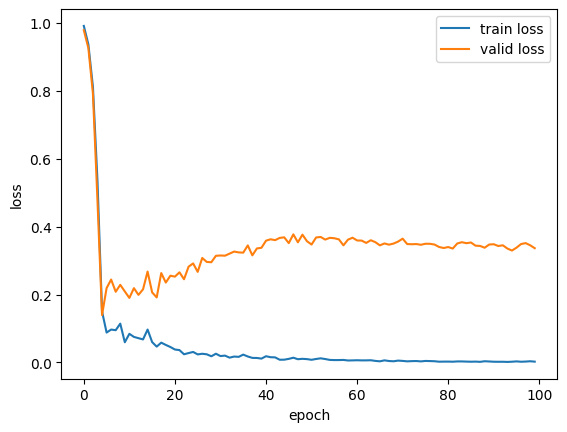

In [14]:
if USE_TENSORBOARD and TRAIN:
	from spektral.data import BatchLoader

	loader_train = BatchLoader(train_data_total, batch_size=batch_size, shuffle=True)
	loader_valid = BatchLoader(valid_data_total, batch_size=batch_size, shuffle=True)

	tb_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(dir_tensorboard, (f'{model_name}_total_lr{lr}'
																   																	f'_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}')))
	log_callback = tf.keras.callbacks.LambdaCallback(
		on_epoch_end=lambda epoch, logs: logging.info(f'total model:{model_name} epoch:{epoch} loss:{logs["loss"]} val_loss:{logs["val_loss"]}')
	)
	save_callback = tf.keras.callbacks.ModelCheckpoint(
		filepath=os.path.join(dir_params, f'{model_name}_total_best_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.h5'),
		monitor='val_loss',
		save_best_only=True,
		save_weights_only=True,
		mode='auto',
		period=1
	)

	# train model
	start = time.time()
	logging.info('----------------model total train start------------------')
	history = model_total.fit(loader_train.load(),
														validation_data=loader_valid.load(),
														steps_per_epoch=loader_train.steps_per_epoch,
														validation_steps=loader_valid.steps_per_epoch,
														epochs=epochs,
														shuffle=False,
														callbacks=[tb_callback, log_callback, save_callback])

	end = time.time()
	logging.info(f'model total train done epoch: {epochs}, time: {end - start}s')
	logging.info('-----------------model total train end-------------------')

	# plot 
	plt.figure()
	plt.plot(history.history['loss'], label='train loss')
	plt.plot(history.history['val_loss'], label='valid loss')
	plt.legend()
	plt.xlabel('epoch')
	plt.ylabel('loss')

	# save picture
	plt_save_path = os.path.join(dir_results, f"{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.jpg")
	plt.savefig(plt_save_path)

#### 模型测试

d:\learn_more_from_life\computer\EDA\work\prj\rc_predict\code\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1/1 [==============================] - 2s 2s/step - loss: 0.9991 - measure_ratio_bad: 1.0000
Model: "gat_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gat_conv_12 (GATConv)       multiple                  896       
                                                                 
 gat_conv_13 (GATConv)       multiple                  3296      
                                                                 
 gat_conv_14 (GATConv)       multiple                  3296      
                                                                 
 global_max_pool_4 (GlobalMa  multiple                 0         
 xPool)                                                          
                                                                 
 dense_8 (Dense)             multiple                  2112      
                                                                 
 dense_9 (Dense)             multi

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 180 and the array at index 1 has size 60

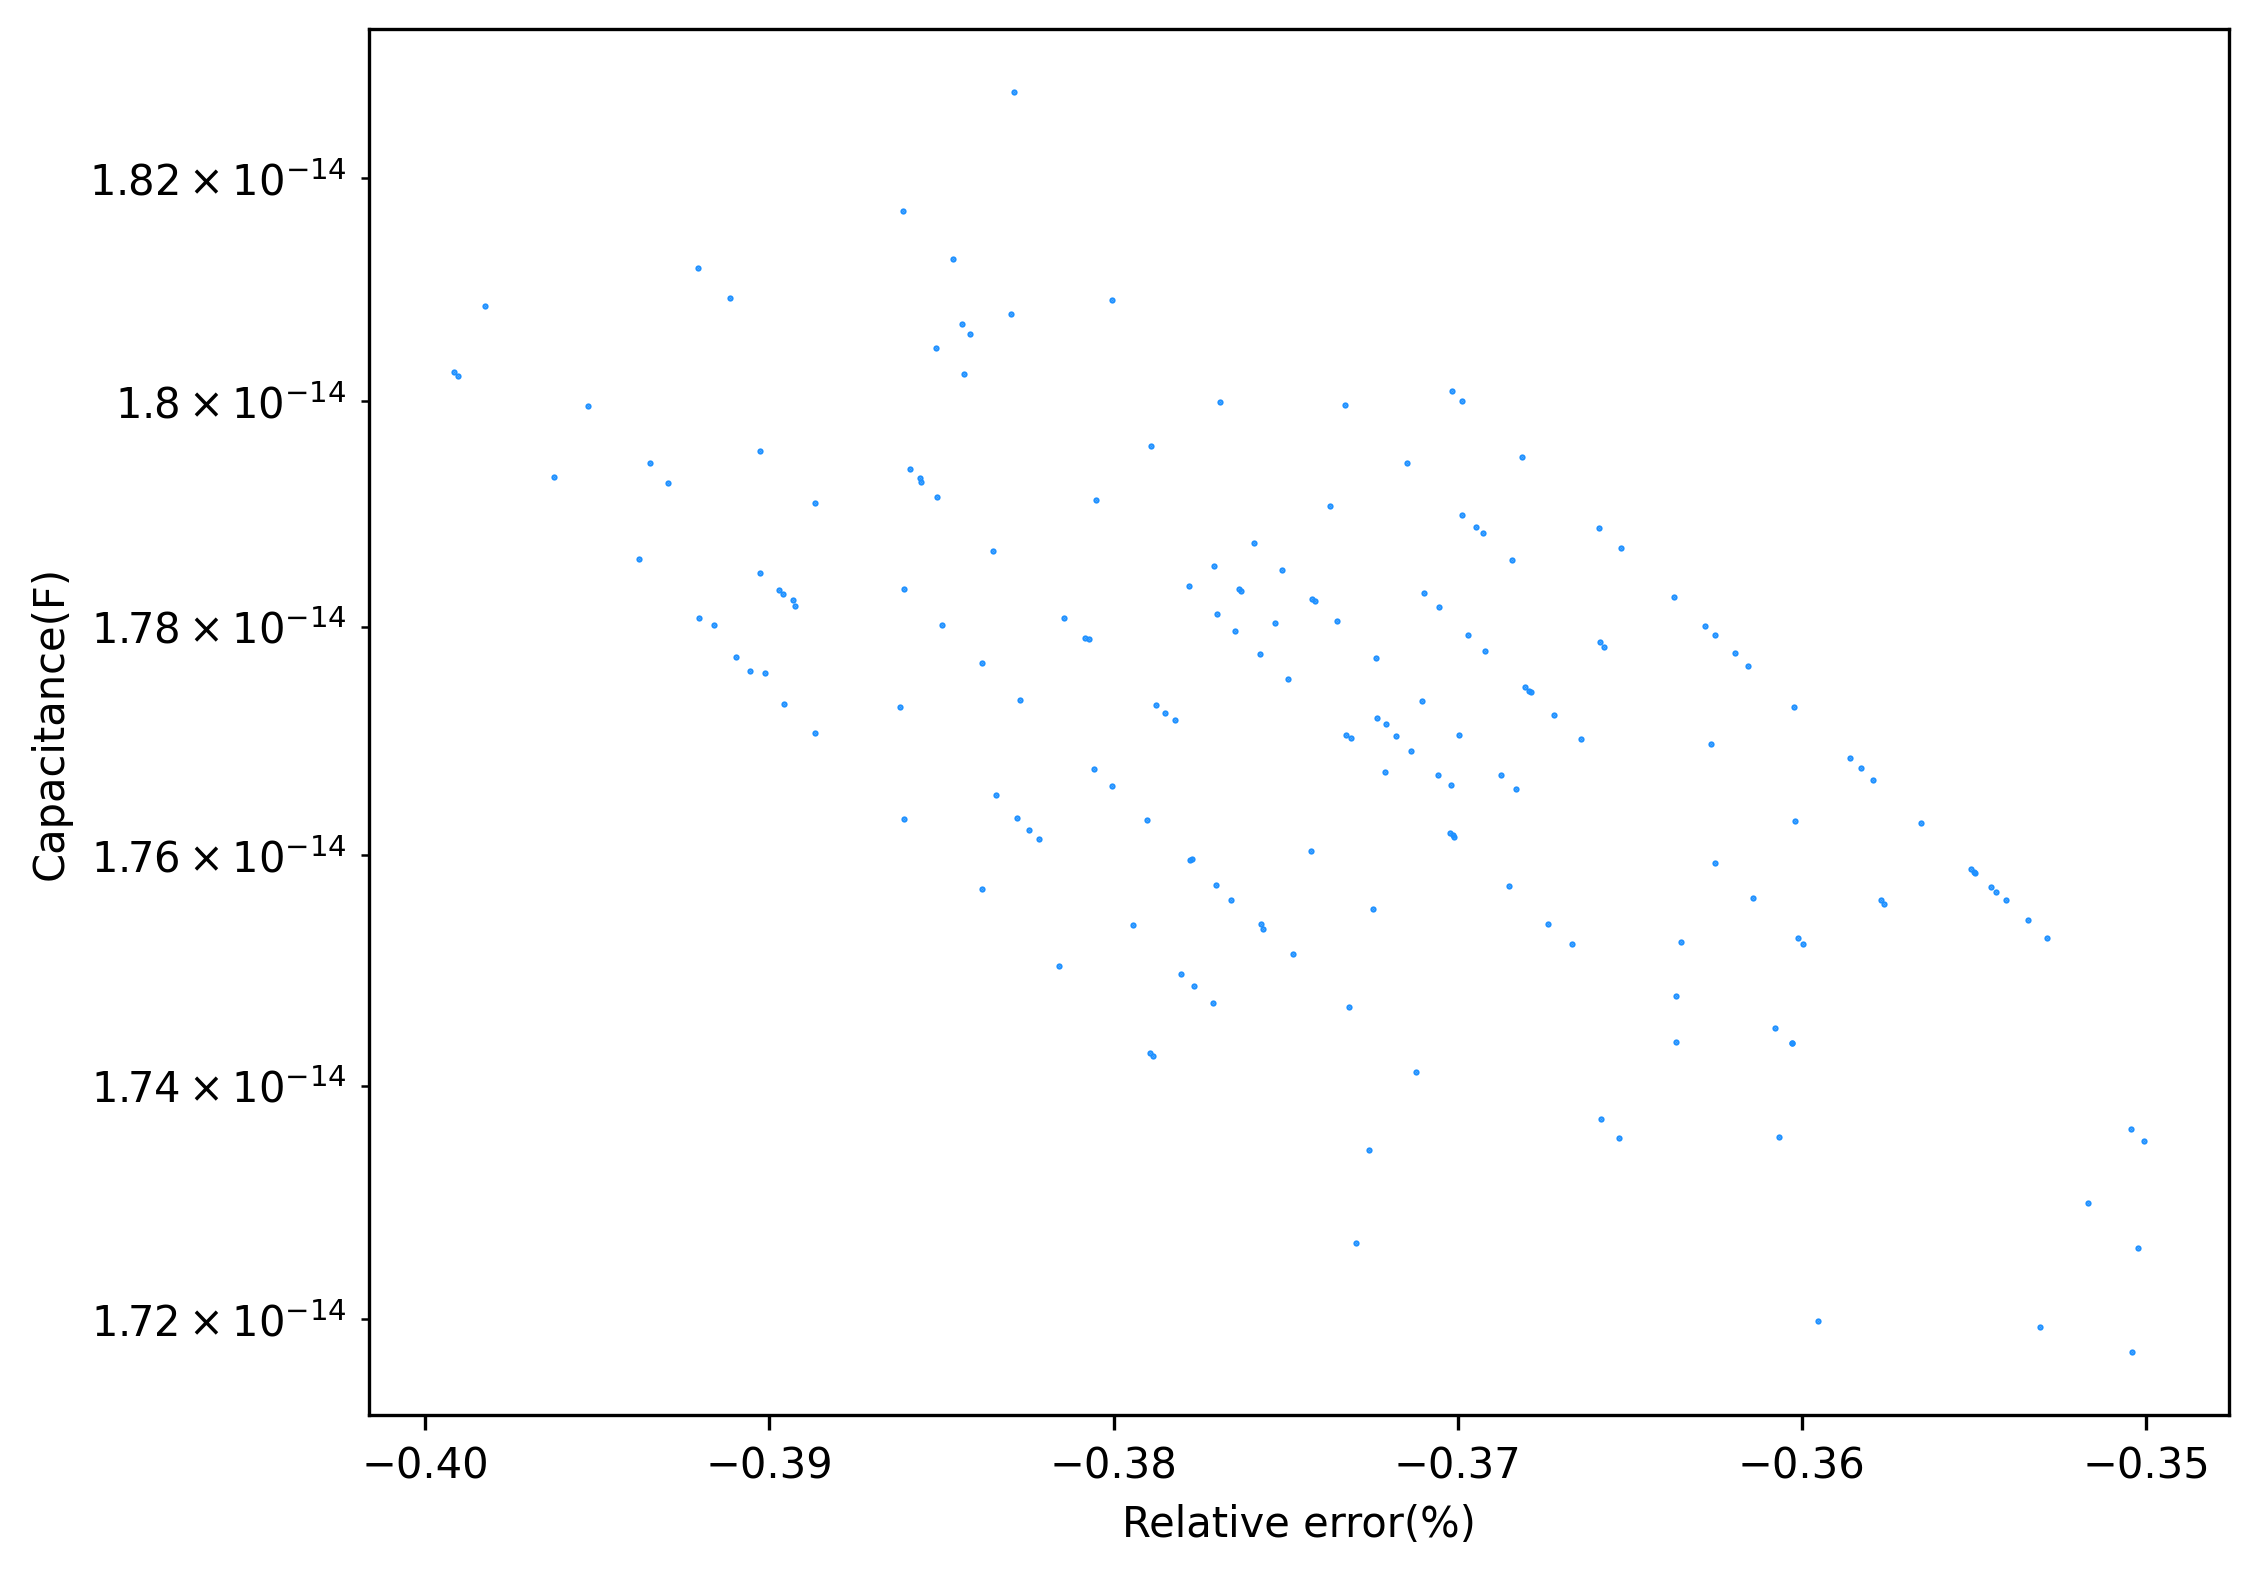

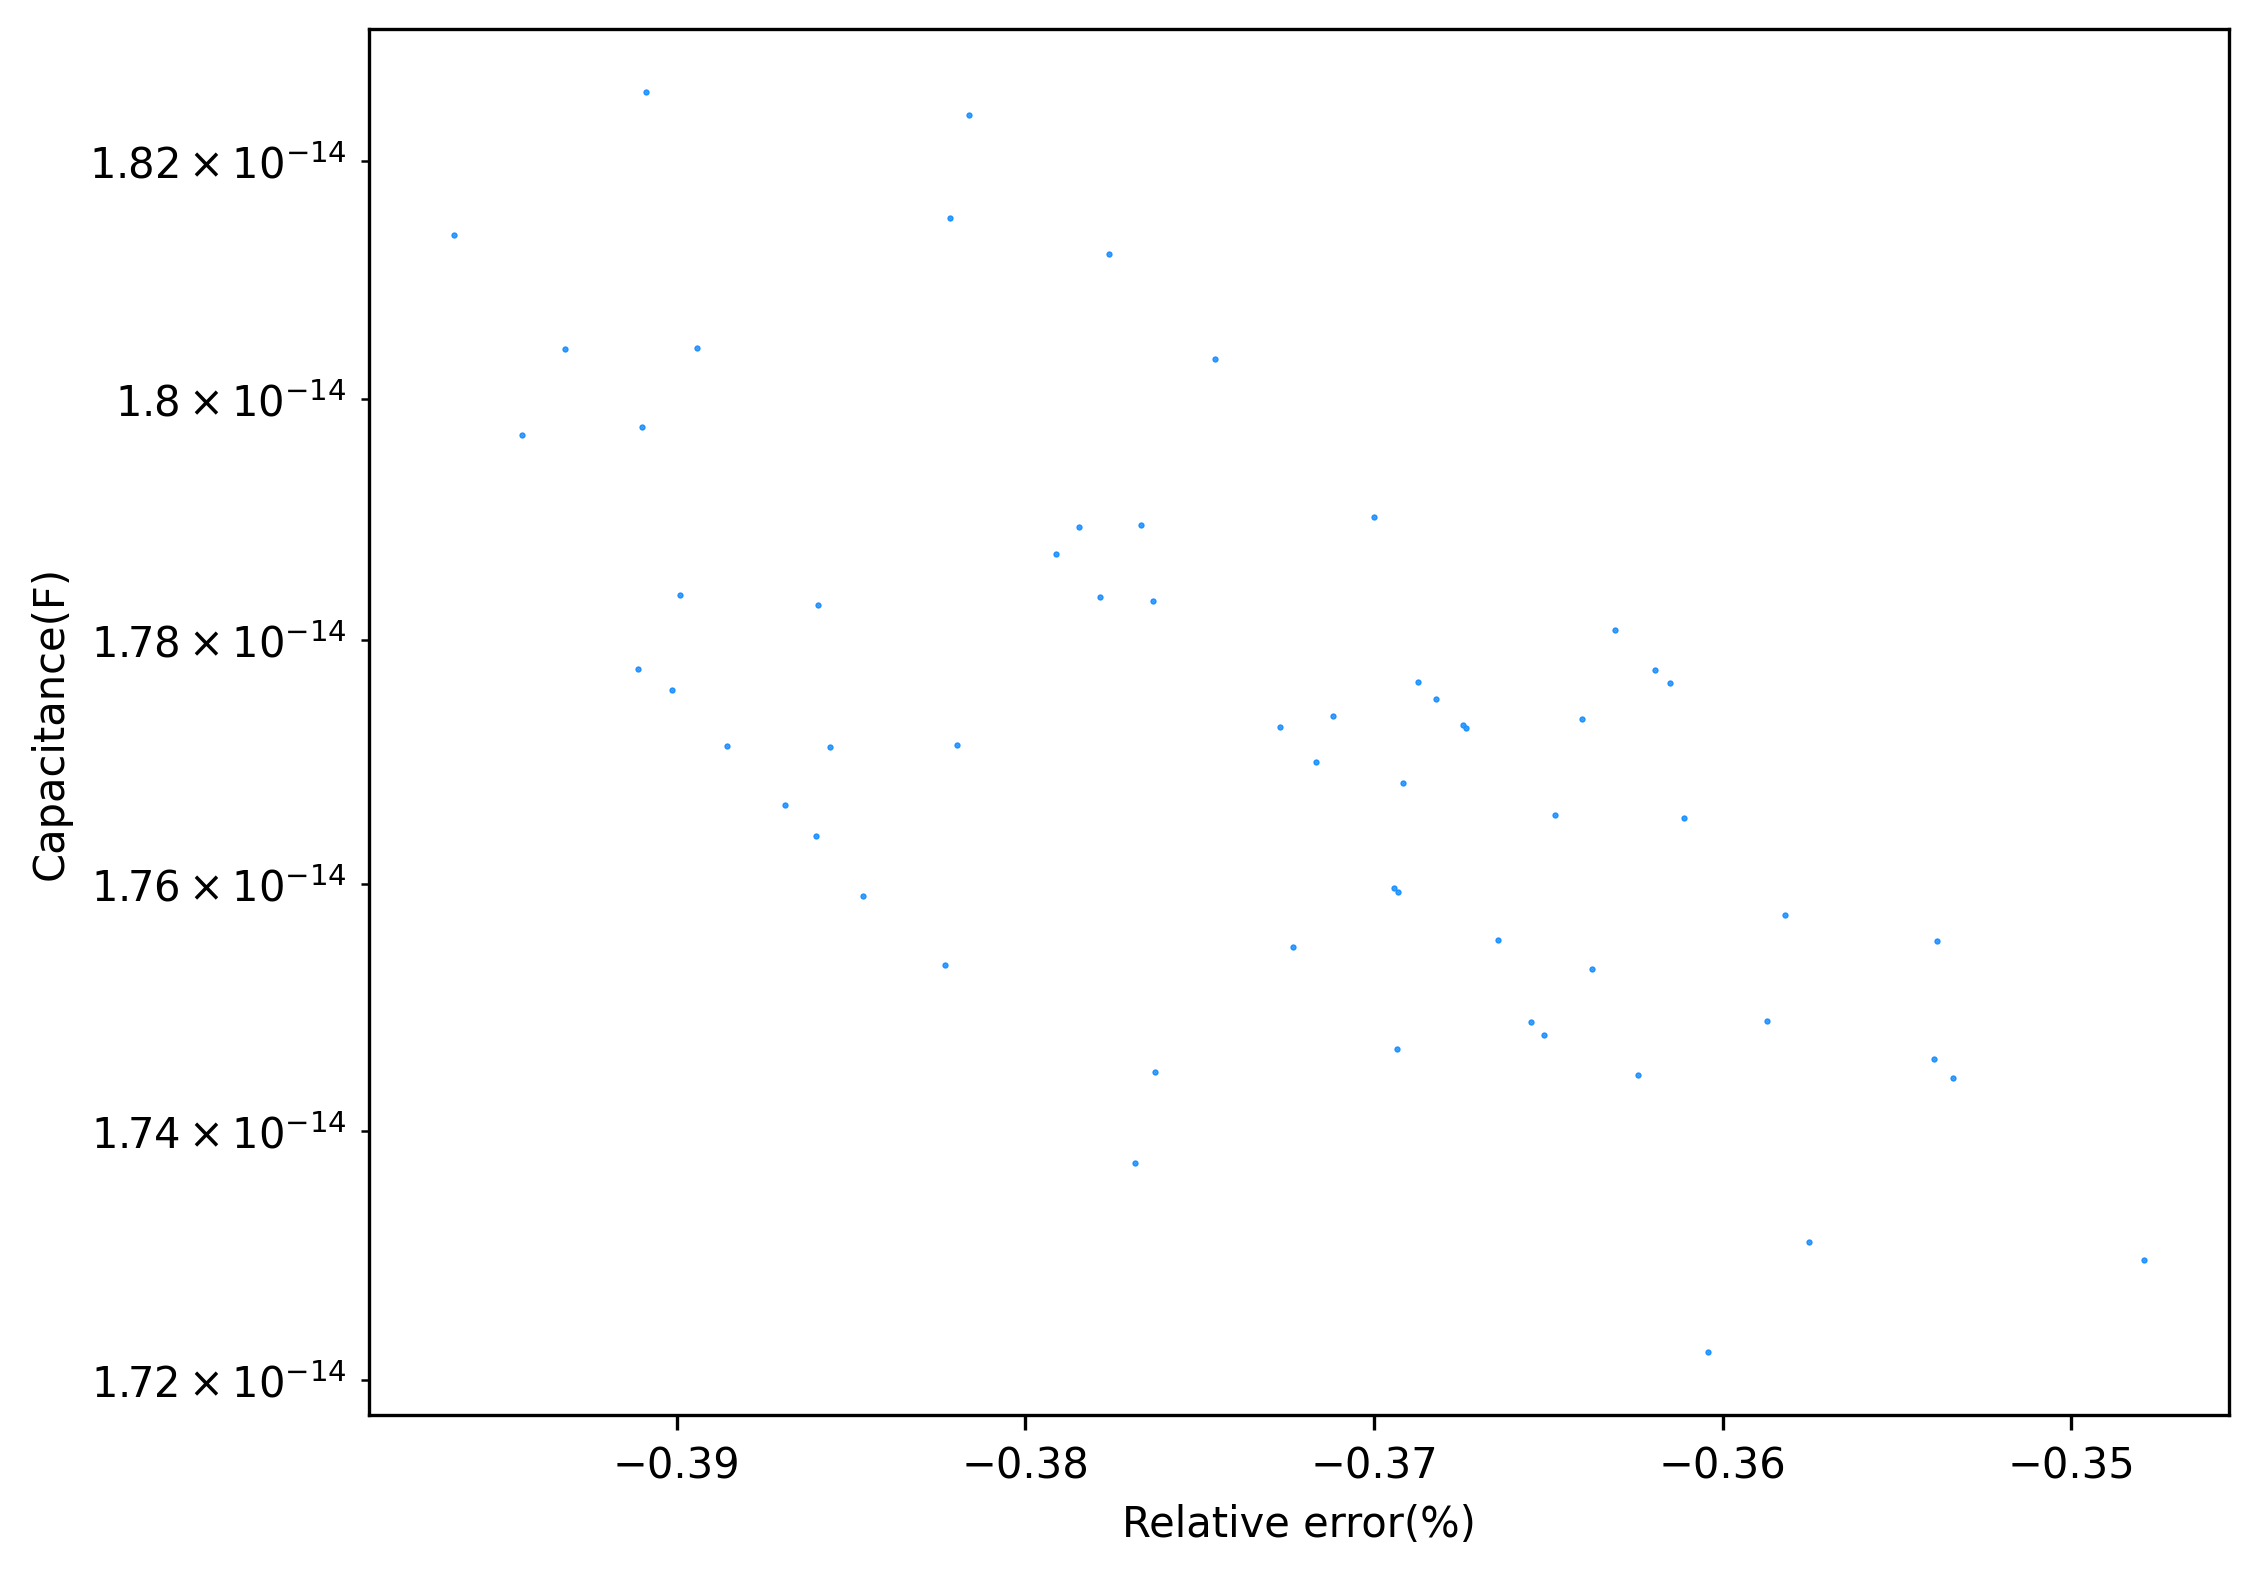

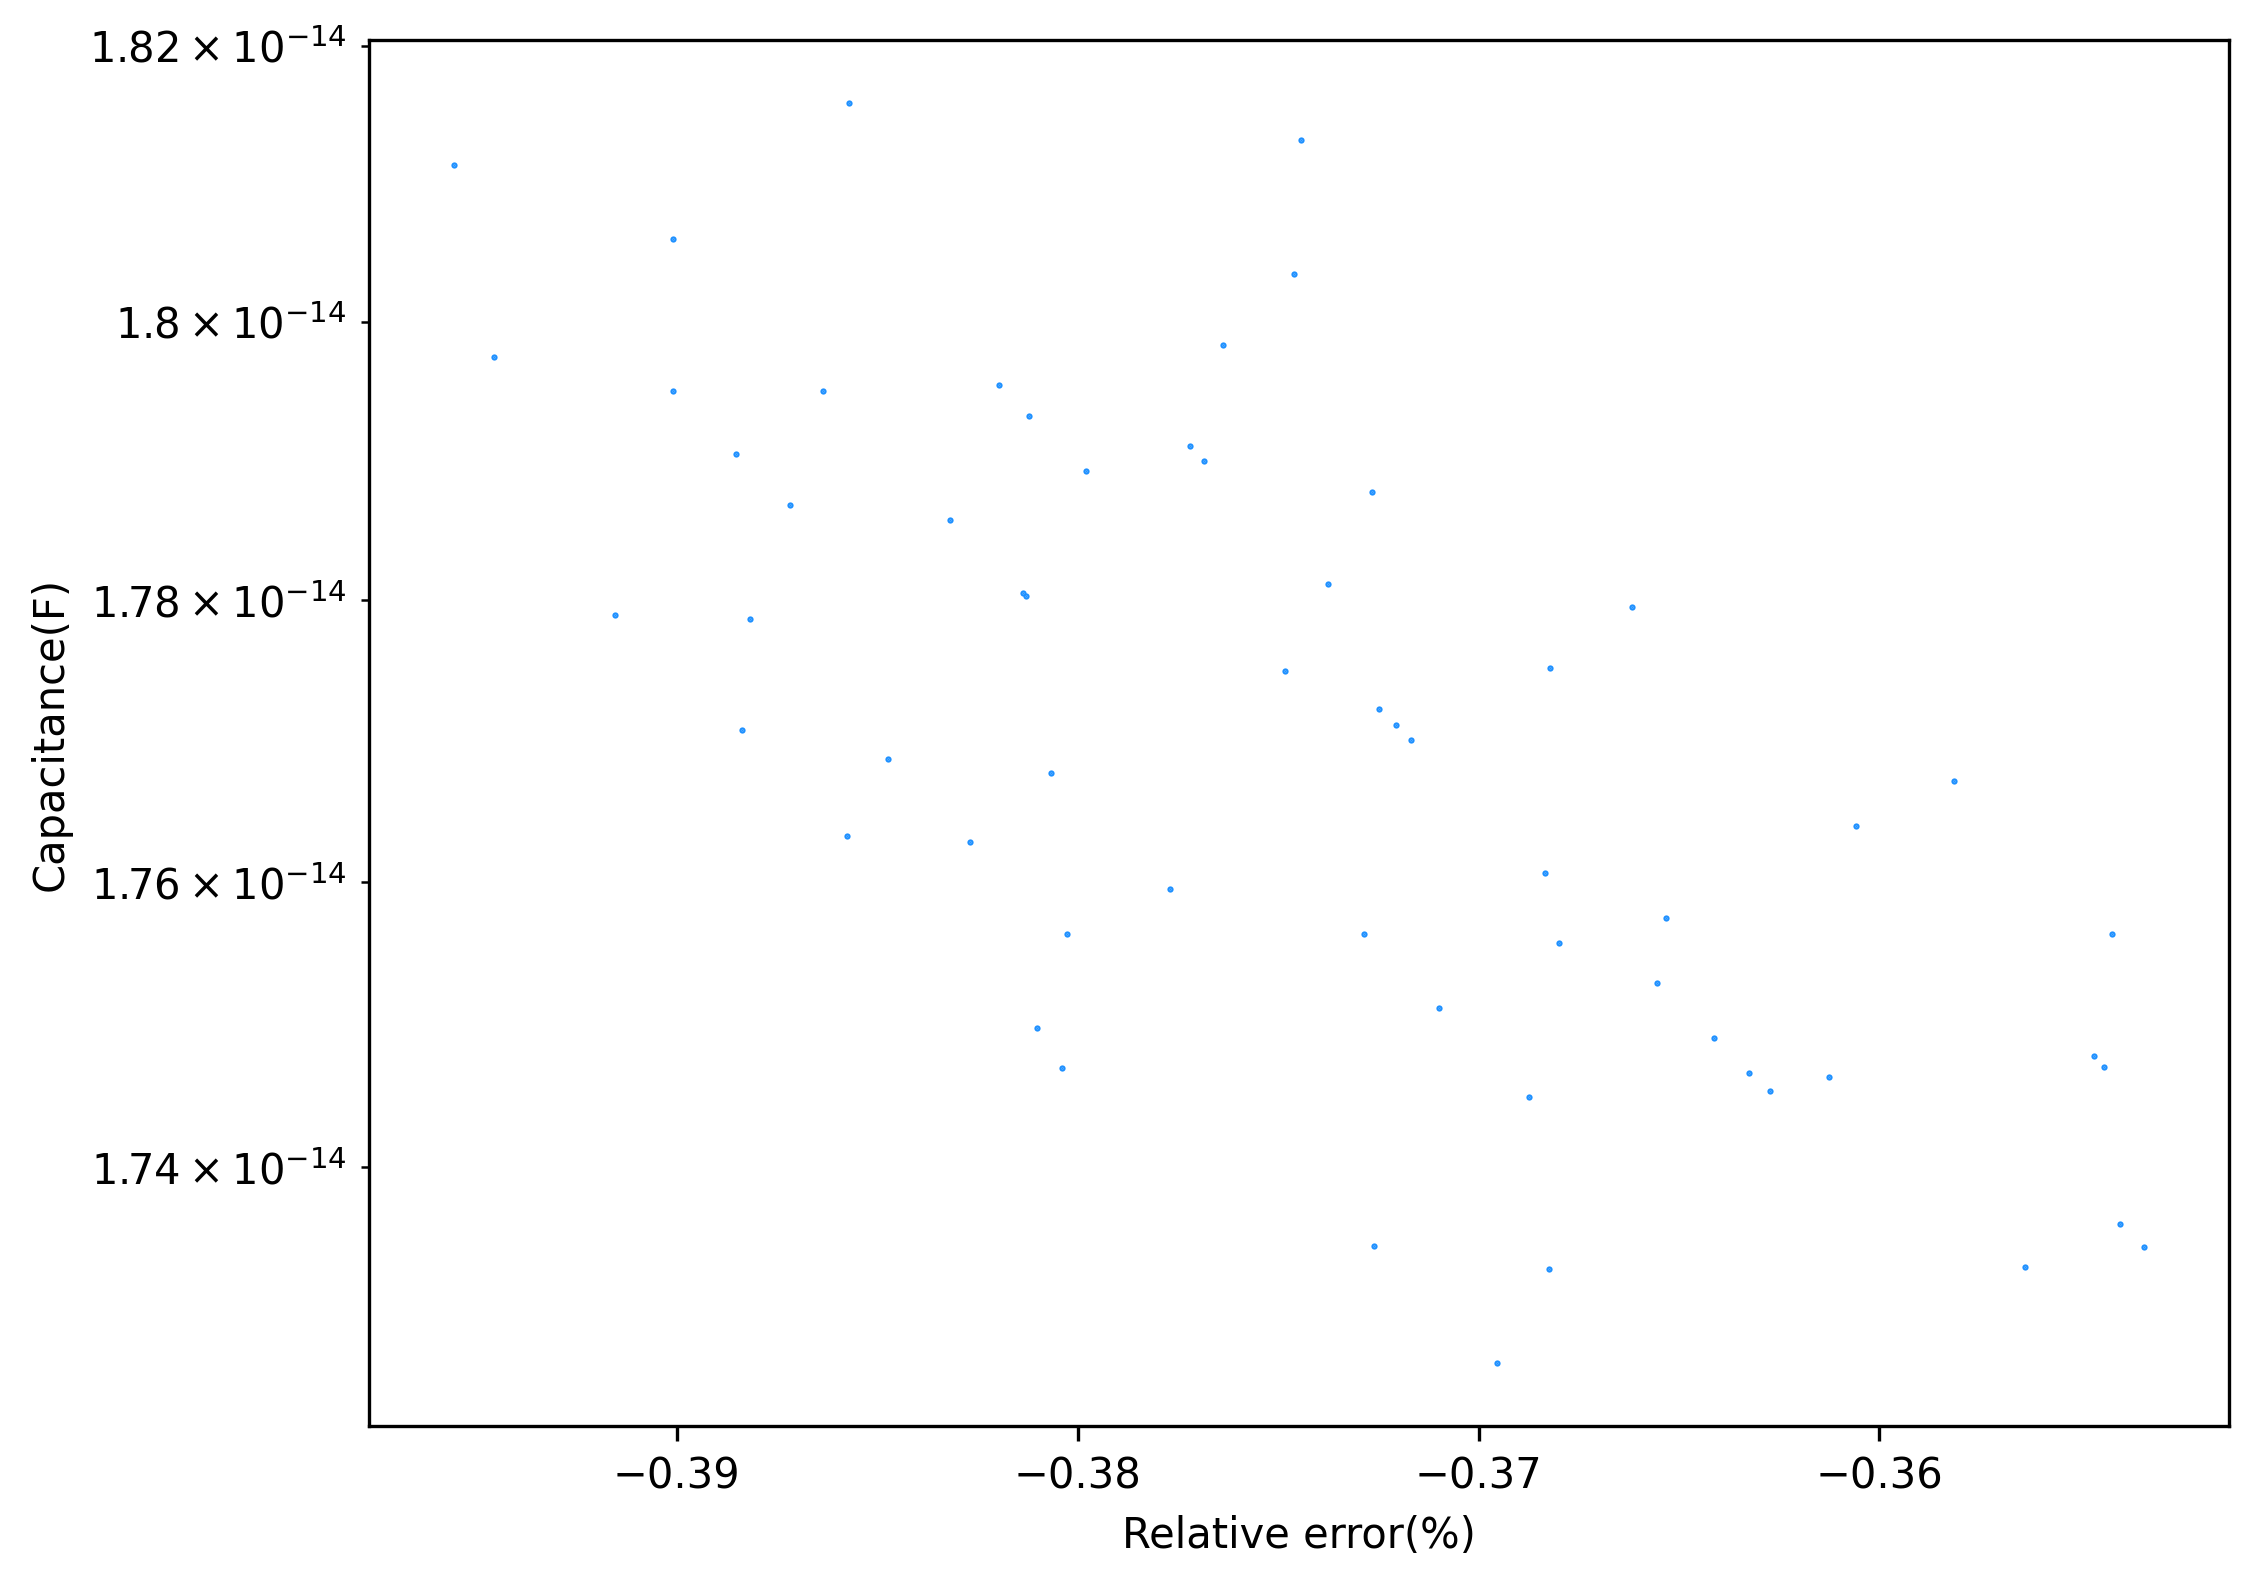

In [15]:
from utils.model import gnn_analysis, gnn_plot


# best model load
# build model
loader = BatchLoader(train_data_total[:batch_size], batch_size=batch_size, shuffle=True)
model_total = GCN(training=False) if model_name == 'gcn' else GraphSage(training=False) if model_name == 'graph_sage' else GAT(training=False)
model_total.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)
model_total.fit(loader.load(),
								steps_per_epoch=1,
								epochs=1)
model_total_load_path = os.path.join(dir_params, f'{model_name}_total_best_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.h5')
if os.path.exists(model_total_load_path):
	model_total.load_weights(model_total_load_path)
else:
	raise ValueError('model total load path does not exist')
model_total.summary()

yt_train = np.array([data.y for data in train_data_total]).reshape(-1, 1)
yt_valid = np.array([data.y for data in valid_data_total]).reshape(-1, 1)
yt_test = np.array([data.y for data in test_data_total]).reshape(-1, 1)

# get table
dict_total = gnn_analysis(model_total, batch_size, 
													train_data_total, yt_train,
													valid_data_total, yt_valid,
													test_data_total, yt_test, name=model_name)
data_total = pd.Series(dict_total).to_frame(name='total').T

# scatter plot
gnn_plot(model_total, batch_size, 
				train_data_total, yt_train,
				valid_data_total, yt_valid,
				test_data_total, yt_test, dir=dir_results,
				name=f'{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}')

# save results
data_total.to_csv(os.path.join(dir_results, f"{model_name}_total_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.csv"), index=False)


### 耦合电容模型

#### 模型训练

##### 手动记录

In [ ]:
if (not USE_TENSORBOARD) and TRAIN:
	from spektral.data import BatchLoader
	from utils.model import sync


	loader_train = BatchLoader(train_data_couple, batch_size=batch_size, shuffle=True)
	loader_valid = BatchLoader(valid_data_couple, batch_size=batch_size, shuffle=True)

	best_epoch = 0
	best_val_score = 1e10

	# train model
	loss_all = []
	val_loss_all = []
	start = time.time()
	logging.info('----------------model couple train start------------------')
	for epoch in range(epochs):
		history = model_couple.fit(loader_train.load(),
															validation_data=loader_valid.load(),
															steps_per_epoch=loader_train.steps_per_epoch,
															validation_steps=loader_valid.steps_per_epoch,
															epochs=1,
															shuffle=False)
		loss_all.append(history.history['loss'][0])
		val_loss_all.append(history.history['val_loss'][0])

		# log
		logging.info(f'couple model:{model_name} epoch:{epoch} loss:{loss_all[-1]} val_loss:{val_loss_all[-1]}')

		# save model every model_save_freq epochs
		if (epoch + 1) % model_save_freq == 0:
			model_couple_save_path = os.path.join(dir_params, f'{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epoch}_ndm{ndm}_seed{seed}.h5')
			model_couple.save_weights(model_couple_save_path)

		# save best model on validation set
		val_loss, val_score = model_couple.evaluate(loader_valid.load(), steps=loader_valid.steps_per_epoch)
		if val_score < best_val_score:
			best_epoch = epoch
			best_val_score = val_score
			sync(model_couple, model_best_couple)
	end = time.time()
	logging.info(f'model couple train done epoch: {epochs}, time: {end - start}s')
	logging.info('-----------------model couple train end-------------------')

	# save best model
	model_couple_save_path = os.path.join(dir_params, f'{model_name}_couple_best_lr{lr}_batchsize{batch_size}_epochs{best_epoch}of{epochs}_ndm{ndm}_seed{seed}.h5')
	model_best_couple.save_weights(model_couple_save_path)
	model_couple.summary()

	# plot
	plt.figure()
	plt.plot(loss_all, label='train loss')
	plt.plot(val_loss_all, label='valid loss')
	plt.legend()
	plt.xlabel('epoch')
	plt.ylabel('loss')

	# save picture
	plt_save_path = os.path.join(dir_results, f"{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.jpg")
	plt.savefig(plt_save_path)

##### Tensorboard 使用

In [ ]:
if USE_TENSORBOARD and TRAIN:
	from spektral.data import BatchLoader


	loader_train = BatchLoader(train_data_couple, batch_size=batch_size, shuffle=True)
	loader_valid = BatchLoader(valid_data_couple, batch_size=batch_size, shuffle=True)

	tf_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(dir_tensorboard, (f'{model_name}_couple_lr{lr}'
																																		f'_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}')))
	log_callback = tf.keras.callbacks.LambdaCallback(
		on_epoch_end=lambda epoch, logs: logging.info(f'couple model:{model_name} epoch:{epoch} loss:{logs["loss"]} val_loss:{logs["val_loss"]}')
	)
	save_callback = tf.keras.callbacks.ModelCheckpoint(
		filepath=os.path.join(dir_params, f'{model_name}_couple_best_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.h5'),
		monitor='val_loss',
		save_best_only=True,
		save_weights_only=True,
		mode='auto',
		period=1
	)

	start = time.time()
	logging.info('----------------model couple train start------------------')
	history = model_couple.fit(loader_train.load(),
														validation_data=loader_valid.load(),
														steps_per_epoch=loader_train.steps_per_epoch,
														validation_steps=loader_valid.steps_per_epoch,
														epochs=epochs,
														shuffle=False,
														callbacks=[tf_callback, log_callback, save_callback])

	end = time.time()
	logging.info(f'model couple train done epoch: {epochs}, time: {end - start}s')
	logging.info('-----------------model couple train end-------------------')

	# plot 
	plt.figure()
	plt.plot(history.history['loss'], label='train loss')
	plt.plot(history.history['val_loss'], label='valid loss')
	plt.legend()
	plt.xlabel('epoch')
	plt.ylabel('loss')

	# save picture
	plt_save_path = os.path.join(dir_results, f"{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.jpg")
	plt.savefig(plt_save_path)

#### 模型测试

In [ ]:
from utils.model import gnn_analysis


# load best model
# build model
loader = BatchLoader(train_data_couple[:batch_size], batch_size=batch_size, shuffle=True)
model_couple = GCN(training=False) if model_name == 'gcn' else GraphSage(training=False) if model_name == 'graph_sage' else GAT(training=False)
model_couple.compile(optimizer=Adam(learning_rate=lr, epsilon=epsilon),
											loss=loss_func,
											weighted_metrics=weighted_metrics)
model_couple.fit(loader.load(),
								steps_per_epoch=1,
								epochs=1)
model_couple_save_path = os.path.join(dir_params, f'{model_name}_couple_best_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.h5')
if os.path.exists(model_couple_save_path):
	model_couple.load_weights(model_couple_save_path)
else:
	raise FileNotFoundError(f"model_couple_save_path: {model_couple_save_path} not found!")

yc_train = np.array([data.y for data in train_data_couple]).reshape(-1, 1)
yc_valid = np.array([data.y for data in valid_data_couple]).reshape(-1, 1)
yc_test = np.array([data.y for data in test_data_couple]).reshape(-1, 1)

# get table
dict_couple = gnn_analysis(model_couple, batch_size,
						   train_data_couple, yc_train,
						   valid_data_couple, yc_valid,
						   test_data_couple, yc_test, name=model_name)
data_couple = pd.Series(dict_couple).to_frame(name='couple').T

# scatter plot
gnn_plot(model_couple, batch_size,
				train_data_couple, yc_train,
				valid_data_couple, yc_valid,
				test_data_couple, yc_test, dir=dir_results,
				name=f'{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}')

# save results
data_couple.to_csv(os.path.join(dir_results, f"{model_name}_couple_lr{lr}_batchsize{batch_size}_epochs{epochs}_ndm{ndm}_seed{seed}.csv"), index=False)